In [107]:
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [108]:
mgmt_labels = pd.read_csv("Data/MGMT_YOGANANDA_DATA.csv")

mgmt_labels.head()

,Subject ID,Age,Gender,Histology,Grade,TCGA Data\nCollection,IDH\nmutation\nStatus,1p/19q\nco-\ndeletion\nstatus,MGMT\npromoter\nstatus,Survival\n(months),Karnofsky\nperformance\nscores,Cross-\nvalidation\ngroup
0,TCGA-02-0003,50.0,male,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,4.731106,100.0,2
1,TCGA-02-0006,56.0,female,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,18.333034,80.0,2
2,TCGA-02-0009,61.0,female,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,10.579278,80.0,2
3,TCGA-02-0011,18.0,female,glioblastoma,G4,TCGA-GBM,WT,non-codel,Methylated,20.698587,80.0,2
4,TCGA-02-0027,33.0,female,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,12.156313,100.0,2


In [109]:
files = h5py.File('/data/slow/yogananda.hdf5', 'r')

In [110]:
def get_and_save_patches(brain, mask,  image_name, save_dir, target, patch_size=32, overlap=8):
    
    x_y_size = int((240 - patch_size)/overlap) + 1
    z_size = int((155 - patch_size)/overlap) + 1
    
    brain_patch_list = []
    mask_patches_list = []
    target_list = []
    pixels_in_brain_patch_list = []
    pixels_in_mask_patch_list = []
        
    for x in range(x_y_size):
        for y in range(x_y_size):
            for z in range(z_size):            
                
                brain_patch = brain[overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size]
                mask_patch = mask[overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size]
                   
                pixel_count = mask_patch.sum()
                
                if pixel_count >= 1:
                
                    pixels_in_mask_patch_list.append(pixel_count)           

                    pixel_count = brain_patch.astype(np.float64).sum()                
                    pixels_in_brain_patch_list.append(pixel_count)   

                    brain_patch_list.append(f"{save_dir}/{image_name}_{x}_{y}_{z}.h5")
                    mask_patches_list.append(f"{save_dir}/{image_name}_mask_{x}_{y}_{z}.h5")
                    target_list.append(target)            

                    with h5py.File(f'{save_dir}/{image_name}_{x}_{y}_{z}.h5', 'w') as hf:
                        hf.create_dataset("Slice",  data=brain_patch, chunks=True)
                    with h5py.File(f'{save_dir}/{image_name}_mask_{x}_{y}_{z}.h5', 'w') as hf:
                        hf.create_dataset("Slice",  data=mask_patch, chunks=True)
        
    df = pd.DataFrame(data={
        "brain_patches": brain_patch_list,
        "mask_patches": mask_patches_list,
        "pixels_in_brain_patch": pixels_in_brain_patch_list,
        "pixels_in_mask_patch": pixels_in_mask_patch_list,
        "target": target_list,
    })
    
    return df

In [111]:
id_sel = files["X"].attrs["ids"][0]

In [112]:
mgmt_labels["Subject ID"] = mgmt_labels["Subject ID"].apply(lambda x: x.split("_")[0])

In [113]:
def create_target(target):
    if target == "Unmethylated":
        return 0
    else:
        return 1

In [114]:
mgmt_labels["target"] = mgmt_labels["MGMT\npromoter\nstatus"].apply(create_target)

In [126]:
df_saved = []

for i, f in enumerate(range(files["X"].shape[0])):
    
    x = files["X"][i][1]

    y = files["seg"][i]

    id_sel = files["X"].attrs["ids"][i]
    
    target = mgmt_labels[mgmt_labels["Subject ID"] == id_sel]["target"].values[0]
    
    path = f"Data/Patches_128X128X128/{id_sel}"    
        
    if not os.path.exists(path):
    
        os.mkdir(path)

        df_patches = get_and_save_patches(x, y, f, path, target, 128)
        
        df_saved.append(df_patches)
    
    if i == 1:
        break
    
df_saved = pd.concat(df_saved).reset_index(drop=True)
        
df_saved.to_csv("Data/MGMT_3D_SLICES_32X32X32.csv", index=False)

# Test saved patches

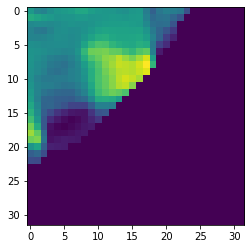

In [11]:
x_dir = df_saved["brain_patches"].values[1230]

with h5py.File(x_dir, "r") as f:
    a_group_key = list(f.keys())[0]
    x = np.array(list(f[a_group_key]))
    
plt.imshow(x[23].astype(np.float32))
plt.show()

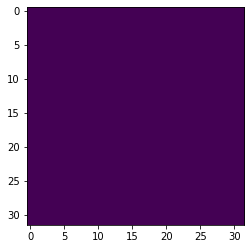

In [12]:
x_dir = df_saved["mask_patches"].values[1230]

with h5py.File(x_dir, "r") as f:
    a_group_key = list(f.keys())[0]
    x = np.array(list(f[a_group_key]))
    
plt.imshow(x[23].astype(np.float32))
plt.show()

# Reconstruct patches

In [32]:
def create_mask_for_normalization(patch_size=32, overlap=8):
       
    mask = np.zeros((240, 240, 155))
    
    z_size = int((155 - patch_size)/overlap) + 1
    x_y_size = int((240 - patch_size)/overlap) + 1
    
    c = 0
        
    for x in range(x_y_size):
        for y in range(x_y_size):
            for z in range(z_size):           
                mask[overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size] += np.ones((patch_size, patch_size, patch_size))
                                
                
    mask[mask == 0] = 1
    
    return mask 

In [34]:
def get_patches_from_input(input_image, patch_size=32, overlap=8):
    
    z_size = int((155 - patch_size)/overlap) + 1
    x_y_size = int((240 - patch_size)/overlap) + 1
    
    patches = []
        
    for x in range(x_y_size):
        for y in range(x_y_size):
            for z in range(z_size):           
                patch = input_image[overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size]
                patches.append(patch)
                
    return patches

In [103]:
mask_for_normalization = create_mask_for_normalization(patch_size=32, overlap=8)

In [104]:
def recreate_brain_from_patches(patches, patch_size=32, overlap=8):
    
    reconstructed_image = np.zeros((240, 240, 155))
    
    z_size = int((155 - patch_size)/overlap) + 1
    x_y_size = int((240 - patch_size)/overlap) + 1
        
    c = 0

    for x in range(x_y_size):
        for y in range(x_y_size):
            for z in range(z_size):            
                reconstructed_image[overlap*x:overlap*x + patch_size, overlap*y:overlap*y + patch_size, overlap*z:overlap*z + patch_size] += patches[c]
                c = c + 1
                    
    reconstructed_image = reconstructed_image/mask_for_normalization
                
    return reconstructed_image

In [105]:
x = files["X"][i][1]

patches = get_patches_from_input(x, patch_size=32, overlap=8)
x_reconstructed = recreate_brain_from_patches(patches, patch_size=32, overlap=8)

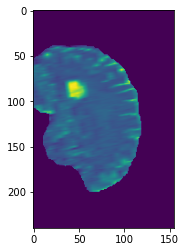

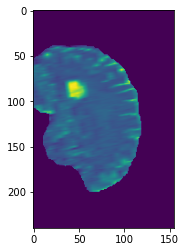

In [106]:
plt.imshow(x[150].astype(np.float32))
plt.show()

# plt.imshow(patches[150][50].astype(np.float32))
# plt.show()

plt.imshow(x_reconstructed[150])
plt.show()